<a href="https://colab.research.google.com/github/NLinh-Tran/Lending-Club-Analysis/blob/main/Trade_Off_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
wordsforthewise_lending_club_path = kagglehub.dataset_download('wordsforthewise/lending-club')

print('Data source import complete.')


Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv


# **INSTALL PYSPARK**

In [3]:
!pip install PySpark

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import logging
import sys
import os
import plotly.express as px

print('Import Libraries')

Import Libraries


In [5]:
spark = SparkSession.builder                                        \
                    .appName("LendingClubAnalysis")                 \
                    .config("spark.ui.showConsoleProgress","false") \
                    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

In [6]:
accepted_df = spark.read.option("header", True)                                             \
                        .option("inferSchema", True)                                        \
                        .option("multiLine", True)                                          \
                        .option("escape", '"')                                              \
                        .csv("/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz")

rejected_df = spark.read.option("header", True)                                            \
                        .option("inferSchema", True)                                        \
                        .option("multiLine", True)                                          \
                        .option("escape", '"')                                              \
                        .csv("/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz")

# **COMBINED DATASET**
* loan_amnt
* emp_length
* accepted_flag

In [7]:
# Accpeted
accepted_c = accepted_df.withColumn('accepted_flag', lit(1)) \
                         .select('id', 'loan_amnt', 'emp_length', 'dti', 'loan_status', 'accepted_flag')

# Rejected
rejected_c = rejected_df.withColumnRenamed('Amount Requested', 'loan_amnt') \
                         .withColumnRenamed('Employment Length', 'emp_length') \
                         .withColumn('dti', regexp_replace(col('Debt-To-Income Ratio'), '%', '').cast('double')) \
                         .withColumn('id', monotonically_increasing_id()) \
                         .withColumn('loan_status', lit('Rejected')) \
                         .withColumn('accepted_flag', lit(0)) \
                         .select('id', 'loan_amnt', 'emp_length', 'dti', 'loan_status', 'accepted_flag')

In [8]:
# Combine 2 datsets
combined_df = accepted_c.union(rejected_c)

combined_df = combined_df.withColumn('emp_length_years',
                                      when(col('emp_length') == '< 1 year', 0)
                                      .when(col('emp_length') == '1 year', 1)
                                      .when(col('emp_length') == '2 years', 2)
                                      .when(col('emp_length') == '3 years', 3)
                                      .when(col('emp_length') == '4 years', 4)
                                      .when(col('emp_length') == '5 years', 5)
                                      .when(col('emp_length') == '6 years', 6)
                                      .when(col('emp_length') == '7 years', 7)
                                      .when(col('emp_length') == '8 years', 8)
                                      .when(col('emp_length') == '9 years', 9)
                                      .when(col('emp_length') == '10+ years', 10)
                                      .when(col('emp_length').isNull(), -1)
                                      .otherwise(-1)) \
                          .filter((col('dti') >= 0) & (col('dti') <= 100))

combined_df = combined_df.drop('emp_length') \
                         .withColumn('is_CO',
                                     when(col('loan_status').isin(['Charged Off', 'Does not meet the credit policy. Status:Charged Off']), 1).otherwise(0)) \
                         .withColumn('dti_capped', when(col('dti') > 40, 40).otherwise(col('dti'))) \
                         .withColumn('loan_amnt_capped', when(col('loan_amnt') > 42500, 42500).otherwise(col('loan_amnt')))

# **MinMax Scaling** & **Retrain the Model**

## **FEATURE IMPORTANCE**

### Coefficients

In [ ]:
feature_cols = ["loan_amnt_capped", "dti_capped", "emp_length_years"]

lr_model = model.stages[-1]

coeffs = lr_model.coefficients.toArray()

coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coefficient": coeffs
})
coef_df["abs_coefficient"] = np.abs(coef_df["coefficient"])
coef_df_sorted = coef_df.sort_values("abs_coefficient", ascending=False)
coef_df_sorted

,feature,coefficient,abs_coefficient
2,emp_length_years,4.600914,4.600914
1,dti_capped,-0.821242,0.821242
0,loan_amnt_capped,0.784724,0.784724


#### Positive loan_amnt coefficient

In [ ]:
loan_bucketed = rescaled_df.withColumn(
    "loan_amnt_bucket",
    when(col("loan_amnt_capped") < 5000, "0–5K")
    .when((col("loan_amnt_capped") >= 5000) & (col("loan_amnt_capped") < 10000), "5–10K")
    .when((col("loan_amnt_capped") >= 10000) & (col("loan_amnt_capped") < 20000), "10–20K")
    .when((col("loan_amnt_capped") >= 20000) & (col("loan_amnt_capped") < 30000), "20–30K")
    .when((col("loan_amnt_capped") >= 30000) & (col("loan_amnt_capped") < 40000), "30–40K")
    .when((col("loan_amnt_capped") >= 40000) & (col("loan_amnt_capped") < 50000), "40–50K")
    .when((col("loan_amnt_capped") >= 50000) & (col("loan_amnt_capped") < 60000), "50–60K")
    .otherwise("60K+")
)


acceptance_by_bucket = loan_bucketed.groupBy("loan_amnt_bucket", "accepted_flag") \
    .agg(count("*").alias("count")) \
    .groupBy("loan_amnt_bucket") \
    .pivot("accepted_flag", [0, 1]) \
    .sum("count") \
    .fillna(0) \
    .withColumnRenamed("0", "rejected") \
    .withColumnRenamed("1", "accepted")


from pyspark.sql.functions import round

acceptance_by_bucket = acceptance_by_bucket.withColumn(
    "acceptance_rate",
    round(col("accepted") / (col("accepted") + col("rejected")) * 100, 2)
).orderBy(col('acceptance_rate').desc()).toPandas()

acceptance_by_bucket

,loan_amnt_bucket,rejected,accepted,acceptance_rate
0,20–30K,3478274,435221,11.12
1,10–20K,7142919,881155,10.98
2,5–10K,5534798,494884,8.21
3,30–40K,2239037,197761,8.12
4,40–50K,812566,33029,3.91
5,0–5K,6430113,214344,3.23


### SHAP Values

In [ ]:
final_train = model.transform(retrain_df).select("features", "accepted_flag")

In [ ]:
accepted = final_train.filter("accepted_flag = 1").sample(False, 0.01, seed=42).limit(1000)
rejected = final_train.filter("accepted_flag = 0").sample(False, 0.01, seed=42).limit(1000)
sample_df = accepted.union(rejected).collect()

In [ ]:
X_train = np.array([row["features"].toArray() for row in sample_df])
y_train = np.array([row["accepted_flag"] for row in sample_df])

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

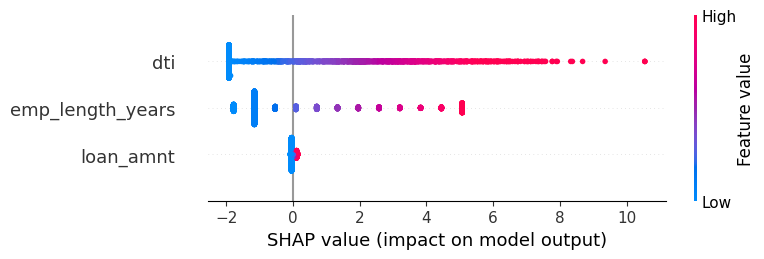

In [ ]:
import shap
explainer = shap.Explainer(clf, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train, feature_names= ["loan_amnt", "dti", "emp_length_years"])

#### Check sample feature range

In [ ]:
accepted = final_train.filter("accepted_flag = 1").sample(False, 0.01, seed=42).limit(1000)
rejected = final_train.filter("accepted_flag = 0").sample(False, 0.01, seed=42).limit(1000)
sample_dist = accepted.union(rejected)

In [ ]:
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col, min, max

# Convert vector column to array column
sample_dist = sample_dist.withColumn("features_array", vector_to_array("features"))

In [ ]:
sample_dist.select(
    min(col("features_array")[0]).alias("min_loan"),
    max(col("features_array")[0]).alias("max_loan")
).show()

+--------------------+-------------------+
|            min_loan|           max_loan|
+--------------------+-------------------+
|0.007058823529411765|0.08235294117647059|
+--------------------+-------------------+



In [ ]:
sample_dist.select(
    min(col("features_array")[1]).alias("min_dti"),
    max(col("features_array")[1]).alias("max_dti")
).show()

+-------+-------+
|min_dti|max_dti|
+-------+-------+
|    0.0|    1.0|
+-------+-------+



In [ ]:
sample_dist.select(
    col("features_array")[2].cast("int").alias("emp_length_years")
).distinct().orderBy("emp_length_years").show()

+----------------+
|emp_length_years|
+----------------+
|               0|
|               1|
+----------------+



In [ ]:
from pyspark.sql.functions import col, when, count, sum, round

# 1. Add DTI buckets (your existing logic)
bucketed_df = combined_df.withColumn(
    "dti_bucket",
    when((col("dti") >= 0) & (col("dti") < 10), "0–10")
    .when((col("dti") >= 10) & (col("dti") < 20), "10–20")
    .when((col("dti") >= 20) & (col("dti") < 30), "20–30")
    .when((col("dti") >= 30) & (col("dti") < 40), "30–40")
    .when((col("dti") >= 40) & (col("dti") < 50), "40–50")
    .when((col("dti") >= 50) & (col("dti") < 60), "50–60")
    .when((col("dti") >= 60) & (col("dti") < 70), "60–70")
    .when((col("dti") >= 70) & (col("dti") < 80), "70–80")
    .when((col("dti") >= 80) & (col("dti") < 90), "80–90")
    .when((col("dti") >= 90) & (col("dti") <= 100), "90–100")
)

# 2. Group by dti_bucket and emp_length_years and compute total + accepted counts
grouped = bucketed_df.groupBy("dti_bucket", "emp_length_years").agg(
    count("*").alias("total_loans"),
    sum(when(col("accepted_flag") == 1, 1).otherwise(0)).alias("accepted_loans")
)

# 3. Calculate acceptance rate
result = grouped.withColumn(
    "acceptance_rate",
    round((col("accepted_loans") / col("total_loans")) * 100, 2)
)

# 4. Show the result
result.orderBy("dti_bucket", "emp_length_years").toPandas()

,dti_bucket,emp_length_years,total_loans,accepted_loans,acceptance_rate
0,0–10,-1,317846,24816,7.81
1,0–10,0,5402102,39597,0.73
2,0–10,1,119657,29248,24.44
3,0–10,2,100423,39669,39.50
4,0–10,3,89940,34612,38.48
...,...,...,...,...,...
115,90–100,6,4898,15,0.31
116,90–100,7,3136,12,0.38
117,90–100,8,4156,19,0.46
118,90–100,9,2856,12,0.42


In [ ]:
# Acceptance rate of dti_bucket where emp_length_years = 0 | 1

result.filter(col("emp_length_years").isin([0, 1])).orderBy("acceptance_rate").toPandas()

,dti_bucket,emp_length_years,total_loans,accepted_loans,acceptance_rate
0,90–100,0,1291879,117,0.01
1,90–100,1,34732,33,0.10
2,50–60,0,825306,953,0.12
3,40–50,0,1733516,2085,0.12
4,60–70,0,404986,522,0.13
5,70–80,0,218125,300,0.14
6,80–90,0,128711,178,0.14
7,30–40,0,2713092,16905,0.62
8,0–10,0,5402102,39597,0.73
9,20–30,0,3916684,52217,1.33


# **class_weight (12.26/1.0)**

* Goal: increase recall rate --> capture more potential borrowers
* Problem: precision rate will be decreased
* Approach: breakdown how much opportunity at each level of risk tolerance

In [9]:
# Specify class_weight
weighted = combined_df.withColumn("class_weight", when(col('accepted_flag') == 1, 12.26).otherwise(1.0))

# Split Train vs Test sets
train_df, test_df = weighted.randomSplit([0.8, 0.2], seed=42)

In [10]:
# Assemble features
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=["loan_amnt_capped", "dti_capped", "emp_length_years", ], outputCol="raw_features")
assembled = assembler.transform(weighted)

In [11]:
# MinMax Scaler
from pyspark.ml.feature import MinMaxScaler
scaler = MinMaxScaler(inputCol="raw_features", outputCol="features")
scaler_model = scaler.fit(assembled)
rescaled_df = scaler_model.transform(assembled)

In [12]:
# Train Logistic Regression Model
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

lr = LogisticRegression(featuresCol="features", labelCol="accepted_flag", weightCol = "class_weight")
pipeline = Pipeline(stages=[assembler, scaler, lr])
weighted_model = pipeline.fit(train_df)

In [19]:
from pyspark.ml.functions import vector_to_array

weighted_predictions = weighted_model.transform(test_df)

weighted_pred_pd = weighted_predictions.select("accepted_flag", "prediction", "probability", "is_CO") \
                                       .withColumn("prob_accepted", vector_to_array(col("probability"))[1])

weighted_pred_pd = weighted_pred_pd.cache()
weighted_pred_pd.count()

from builtins import round as py_round

# Set threshold values to test
thresholds = [x / 100 for x in range(5, 96, 5)]
results = []

for t in thresholds:
    temp = weighted_pred_pd.withColumn(
        "predicted_accept",
        (col("prob_accepted") >= lit(t)).cast("int")
    )

    TP = temp.filter((col("accepted_flag") == 1) & (col("predicted_accept") == 1))
    FP = temp.filter((col("accepted_flag") == 0) & (col("predicted_accept") == 1))
    FN = temp.filter((col("accepted_flag") == 1) & (col("predicted_accept") == 0))

    TP_count = TP.count()
    FP_count = FP.count()
    FN_count = FN.count()

    TP_co = TP.filter(col("is_CO") == 1).count()
    FP_co = FP.filter(col("is_CO") == 1).count()
    All_co = TP_co + FP_co
    predicted_accepted = TP_count + FP_count

    precision = TP_count / predicted_accepted if predicted_accepted > 0 else 0
    recall = TP_count / (TP_count + FN_count) if (TP_count + FN_count) > 0 else 0

    results.append({
        "Threshold": py_round(t, 2),
        "Recall": py_round(recall, 4),
        "Precision": py_round(precision, 4),
        "TP": TP_count,
        "FP": FP_count,
        "Predicted Accepted": predicted_accepted,
        "TP CO Rate": py_round(TP_co / TP_count, 4) if TP_count > 0 else None,
        "FP CO Rate": py_round(FP_co / FP_count, 4) if FP_count > 0 else None,
        "Combined CO Rate": py_round(All_co / predicted_accepted, 4) if predicted_accepted > 0 else None
    })
results_df = spark.createDataFrame(results).toPandas()
results_df = results_df[[
        "Threshold",
        "Recall",
        "Precision",
        "TP",
        "FP",
        "Predicted Accepted",
        "TP CO Rate",
        "FP CO Rate",
        "Combined CO Rate"
    ]]

results_df

,Threshold,Recall,Precision,TP,FP,Predicted Accepted,TP CO Rate,FP CO Rate,Combined CO Rate
0,0.05,1.0000,0.0809,451441,5127930,5579371,0.1196,0.0,0.0097
1,0.10,1.0000,0.0809,451441,5127930,5579371,0.1196,0.0,0.0097
2,0.15,0.9851,0.0806,444733,5075824,5520557,0.1189,0.0,0.0096
3,0.20,0.9466,0.0952,427334,4059152,4486486,0.1179,0.0,0.0112
4,0.25,0.9087,0.1287,410236,2776960,3187196,0.1174,0.0,0.0151
5,0.30,0.8667,0.2207,391244,1381237,1772481,0.1174,0.0,0.0259
6,0.35,0.8320,0.2964,375578,891450,1267028,0.1174,0.0,0.0348
7,0.40,0.7966,0.3349,359633,714181,1073814,0.1173,0.0,0.0393
8,0.45,0.7628,0.3516,344348,634986,979334,0.1170,0.0,0.0411
9,0.50,0.7239,0.3494,326788,608586,935374,0.1172,0.0,0.0409


## Evaluations - Confusion Matrix, AUC

              precision    recall  f1-score   support

    Rejected       0.97      0.88      0.92   5127930
    Accepted       0.35      0.72      0.47    451441

    accuracy                           0.87   5579371
   macro avg       0.66      0.80      0.70   5579371
weighted avg       0.92      0.87      0.89   5579371



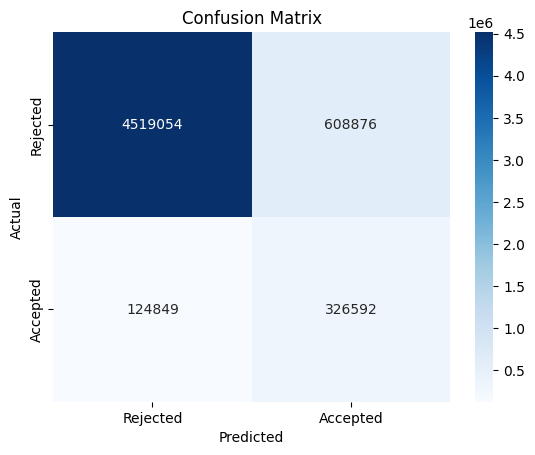

AUC: 0.8584029698971046


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
weighted_predictions = weighted_model.transform(test_df)
weighted_pred_pd = weighted_predictions.select("accepted_flag", "prediction", "probability").toPandas()
print(classification_report(weighted_pred_pd["accepted_flag"], weighted_pred_pd["prediction"], target_names=["Rejected", "Accepted"]))

# Visualize Confusion Matrix
cm = confusion_matrix(weighted_pred_pd["accepted_flag"], weighted_pred_pd["prediction"])
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Rejected", "Accepted"], yticklabels=["Rejected", "Accepted"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# AUC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="accepted_flag")
print("AUC:", evaluator.evaluate(weighted_predictions))

## Precision-Recall Curve

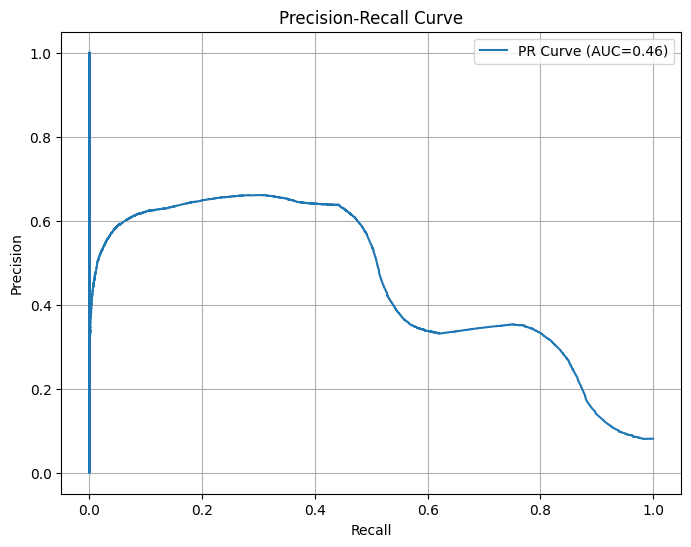

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Extract probability of being Accepted (class 1)
preds_pd['y_probs'] = preds_pd['probability'].apply(lambda x: float(x[1]))
y_test = preds_pd["accepted_flag"]
y_probs = preds_pd["y_probs"]

# y_test: actual labels (0 or 1), y_probs: predicted probabilities for class 1
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Optional: AUC-PR
auc_pr = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC={auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

## Precision-Recall Thresholds

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from builtins import round as py_round

# Extract predictions
weighted_pred_pd['prob_accepted'] = weighted_pred_pd['probability'].apply(lambda x: float(x[1]))

# Set threshold values to test
thresholds = np.arange(0.05, 0.96, 0.05)
results = []

# Loop through thresholds
for t in thresholds:
    weighted_pred_pd["predicted_accept"] = (weighted_pred_pd["prob_accepted"] >= t).astype(int)

    TP = ((weighted_pred_pd["accepted_flag"] == 1) & (weighted_pred_pd["predicted_accept"] == 1)).sum()
    FP = ((weighted_pred_pd["accepted_flag"] == 0) & (weighted_pred_pd["predicted_accept"] == 1)).sum()
    FN = ((weighted_pred_pd["accepted_flag"] == 1) & (weighted_pred_pd["predicted_accept"] == 0)).sum()

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    results.append({
        "Threshold": py_round(t, 2),
        "Recall": py_round(recall, 4),
        "Precision": py_round(precision, 4),
        "TP": TP,
        "FP": FP,
        "Predicted Accepted": TP + FP
    })

results_df = pd.DataFrame(results)
results_df

,Threshold,Recall,Precision,TP,FP,Predicted Accepted
0,0.05,1.0000,0.0809,451441,5127930,5579371
1,0.10,1.0000,0.0809,451441,5127930,5579371
2,0.15,0.9852,0.0806,444760,5075779,5520539
3,0.20,0.9463,0.0952,427204,4060190,4487394
4,0.25,0.9086,0.1287,410195,2778179,3188374
5,0.30,0.8667,0.2206,391279,1382038,1773317
6,0.35,0.8320,0.2965,375611,891402,1267013
7,0.40,0.7966,0.3351,359609,713479,1073088
8,0.45,0.7624,0.3514,344170,635151,979321
9,0.50,0.7234,0.3491,326592,608876,935468


* TP: model predicts "Accepted" and they truly were accepted
* FP: model predicts "Accepted" and they were actually rejected by Lending Club

Aim to increasing FP --> expand the funnel

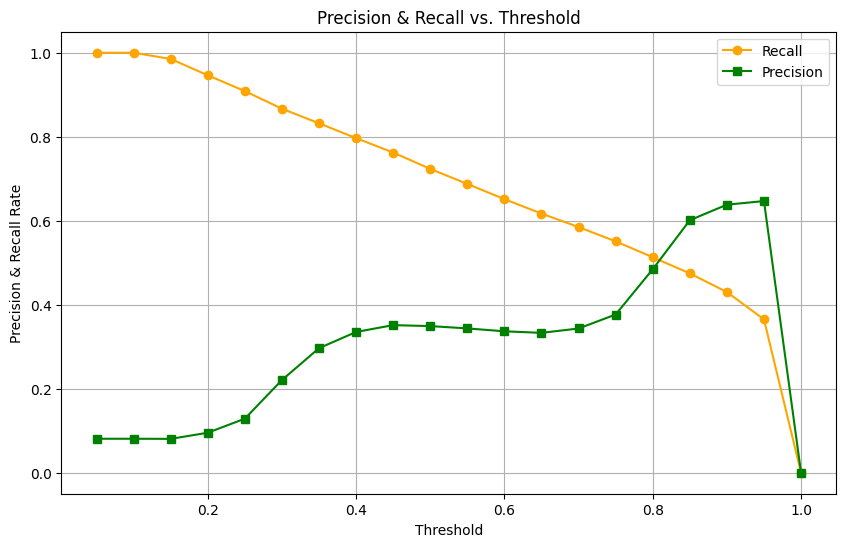

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(results_df["Threshold"], results_df["Recall"], marker='o', label='Recall', color='orange')
plt.plot(results_df["Threshold"], results_df["Precision"], marker='s', label='Precision', color='green')
plt.xlabel("Threshold")
plt.ylabel("Precision & Recall Rate")
plt.title("Precision & Recall vs. Threshold")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=results_df["Threshold"], y=results_df["Recall"],
    mode='lines+markers',
    name='Recall'
))

fig.add_trace(go.Scatter(
    x=results_df["Threshold"], y=results_df["Precision"],
    mode='lines+markers',
    name='Precision'
))

fig.update_layout(
    title="Precision & Recall vs. Threshold",
    xaxis_title="Threshold",
    yaxis_title="Precision & Recall Rate",
    template="plotly_white",
    legend=dict(x=1, y=1),
    hovermode="x unified"
)

fig.show()
